# Accessing data about newspaper & gazette issues

```{attention}
This guide is currently under development. For more information and discussion see [the list of issues](https://github.com/wragge/trove-data-guide/issues) on GitHub. Comments are welcome.
```

```{contents}
:local:
```

In [2]:
import datetime
import os

import altair as alt
import pandas as pd
import requests
from dotenv import load_dotenv
from IPython.display import HTML, JSON
from myst_nb import glue

load_dotenv()
YOUR_API_KEY = os.getenv("TROVE_API_KEY")

## What are issues?

An issue is a single edition of a newspaper published on a particular date. Some newspapers published multiple editions each day, however, Trove holds only one edition per day for each newspaper. This means that issues in Trove can be identified and analysed by date.

## Issue links and identifiers

Issues also have their own unique identifiers assigned by Trove. These identifiers don't appear anywhere within the Trove web interface, but you can [find them using the `newspaper/title` and `gazette/title` endpoints](issues-within-a-date-range) as described below. Issue identifiers look like this: `https://nla.gov.au/nla.news-issue55379`.

Issues don't have their own landing pages, or API endpoints. If you plug an issue identifier into your web browser you'll be redirected to the first page of that issue. This provides a useful mechanism for finding the front pages of issues.

The only instance where an issue exists as a separate entity is if you [download an issue as a PDF](download-issue-as-pdf). This can be automated by using the issue's numeric identifier.

Article records don't include issue identifiers, but articles can be linked to issues through their date.

## Issue metadata

Some issue metadata is available via the `newspaper/title` and `gazette/title` endpoints. You can also find details of articles published within an issue by searching for a specific day and newspaper using the `/result` endpoint.

### Get the number of issues per year for a title

````{margin}
```{seealso}
The GLAM Workbench notebook [Harvest information about newspaper issues](https://glam-workbench.net/trove-newspapers/harvest_newspaper_issues/) includes more information about harvesting issue details from the `newspaper/title` and `gazette/title` endpoints.
```
````

You can use the `newspaper/title` and `gazette/title` endpoints to get the total number of digitised issues per year for a newspaper or gazette title. You just add the `include` parameter and set its value to `years`.

[![Try it!](../images/try-trove-api-console.svg)](https://troveconsole.herokuapp.com/v3/?url=https%3A%2F%2Fapi.trove.nla.gov.au%2Fv3%2Fnewspaper%2Ftitle%2F11%3Fencoding%3Djson%26include%3Dyears)

Here's an example getting the number of issues per year from the *Canberra Times* (whose title identifier is `11`).

In [3]:
title_id = "11"
params = {"encoding": "json", "include": "years"}

# Supply API key using headers
headers = {"X-API-KEY": YOUR_API_KEY}

url = f"https://api.trove.nla.gov.au/v3/newspaper/title/{title_id}"
response = requests.get(url, params=params, headers=headers)
data = response.json()
year_totals = data["year"]

# Show the first 5 values
year_totals[0:5]

[{'date': '1926', 'issuecount': 18},
 {'date': '1927', 'issuecount': 86},
 {'date': '1928', 'issuecount': 285},
 {'date': '1929', 'issuecount': 312},
 {'date': '1930', 'issuecount': 311}]

To find the total number of issues for a title, you just add up all the `issuecount` values.

In [5]:
# Convert the list of counts by year into a dataframe
df_years = pd.DataFrame(year_totals)

# Add all the issuecount values together
df_years["issuecount"].sum()

22148

`````{margin}
````{seealso}
The GLAM Workbench includes a [visualisation of the number of issues per day](https://glam-workbench.net/examples/trove_newspaper_issues_per_day.html) across all of Trove's newspapers.
```{image} /images/issues-per-day.png
:alt: Screencapture of calendar-style visualisation showing the number of issues per day.
:align: center
:width: 80%
```
````
`````
You can use the issue counts to explore changes in the publication frequency of a newspaper. This chart shows the number of issues of the *Canberra Times* published each year. Can you work out when the *Canberra Times* started publishing seven days a week?

In [14]:
chart_issues = alt.Chart(df_years).mark_bar(size=7).encode(
    x="date:T",
    y=alt.Y("issuecount:Q", title="number of issues"),
    tooltip=["date:T","issuecount:Q"]
).properties(width=600)

glue("canberra_times_issues", chart_issues)

alt.Chart(...)

```{glue:figure} canberra_times_issues
```

(issues-within-a-date-range)=
### Details of issues within a date range

You can also use the `newspaper/title` and `gazette/title` endpoints to get some details about individual issues, including their date and identifier. To do this you add the `range` parameter to your request, and set its value to a date range using the format `YYYYMMDD-YYYYMMDD`. For example to find issues published between 1930 and 1935, you'd set the `range` parameter to `19300101-19351231`.

[![Try it!](../images/try-trove-api-console.svg)](https://troveconsole.herokuapp.com/v3/?url=https%3A%2F%2Fapi.trove.nla.gov.au%2Fv3%2Fnewspaper%2Ftitle%2F11%3Fencoding%3Djson%26include%3Dyears%26range%3D19300101-19351231)

You could use the title's `startDate` and `endDate` values to construct the range. However, keep in mind that if a newspaper was published daily over a long period you might be asking for a lot of data in one hit. It might be better to request the data in chunks, such as a year at a time. The GLAM Workbench provides an example of this in the [Harvest information about newspaper issues](https://glam-workbench.net/trove-newspapers/#harvest-information-about-newspaper-issues) notebook.

For years within the requested range, an additional `issue` value will provide a list of available issues published in that year. Each issue will include values for `id`, `date`, and `url`.

Here's an example using the range `19300101-19351231` for the *Canberra Times*.

In [10]:
params = {"encoding": "json", "include": "years", "range": "19300101-19351231"}

url = f"https://api.trove.nla.gov.au/v3/newspaper/title/{title_id}"
response = requests.get(url, params=params, headers=headers)
data = response.json()
years = data["year"]

# Let's get issue details for our range
issues = []
for year in years:
    # If the year is in our range it will include an `issue` value
    if "issue" in year:
        # Add this year's issues
        issues += year["issue"]

# Show the first 5 issues
issues[0:5]

[{'id': '55379',
  'date': '1930-01-01',
  'url': 'https://nla.gov.au/nla.news-issue55379'},
 {'id': '55380',
  'date': '1930-01-02',
  'url': 'https://nla.gov.au/nla.news-issue55380'},
 {'id': '55381',
  'date': '1930-01-03',
  'url': 'https://nla.gov.au/nla.news-issue55381'},
 {'id': '55382',
  'date': '1930-01-04',
  'url': 'https://nla.gov.au/nla.news-issue55382'},
 {'id': '55383',
  'date': '1930-01-06',
  'url': 'https://nla.gov.au/nla.news-issue55383'}]

```{note}
You might be wondering where an issue's `url` actually goes to, as there's no issue landing page in Trove. If you try clicking on one of the links, you'll notice that you're redirected from the issue url to a url that points to the first page of that issue. This provides a useful shortcut if you want to assemble a collection of front pages ([see below for details](get-a-list-of-front-page-urls)).
```

(articles-in-an-issue)=
### Articles in an issue

To get details of all the articles within an issue, you need to construct a search for articles using the `/result` endpoint that specifies the title (the newspaper name) and the publication date.

The newspaper title is set using the `l-title` parameter. For example, the identifier for the *Canberra Times* is `11`, so to limit your search to the *Canberra Times* you'd set `l-title` to `11`.

The date is set [using the `date` index](using-the-date-index) within the `q` (query) parameter. You use the `date` index by supplying a date range. To limit results to a single day you need to set the first date in the range to the day **before** the date you want. The dates need to be in ISO format – `YYYY-MM-DDT00:00:00Z`. For example, if we wanted an articles from 2 November 1942, we'd set the `q` parameter to `date:[1942-11-01T00:00:00Z TO 1942-11-02T00:00:00Z]`.

So to find all articles from the 2 November 1942 issue of the *Canberra Times*, you'd set the following parameters:

- `category=newspaper`
- `l-title=11`
- `q=date:[1942-11-01T00:00:00Z TO 1942-11-02T00:00:00Z]`

[![Try it!](https://troveconsole.herokuapp.com/static/img/try-trove-api-console.svg)](https://troveconsole.herokuapp.com/v3/?url=https%3A%2F%2Fapi.trove.nla.gov.au%2Fv3%2Fresult%3Fq%3Ddate%3A%5B1942-11-01T00%3A00%3A00Z+TO+1942-11-02T00%3A00%3A00Z%5D%26category%3Dnewspaper%26l-title%3D11%26encoding%3Djson&comment=)

This search returns 71 results, fewer than the maximum number of results per request which you can set to `100` using the `n` parameter. This means you can get all the results with one API request. However, many issues will have more than 100 results, in which case you'll need to make multiple API requests. See [](/how-to/harvest-complete-results) for more information.

An alternative approach would be to harvest results from a particular newspaper across a larger date range (months or years) and then aggregate the results by date. <mark>==Create an example of this using the Newspaper Harvester?==</mark>

## Issue text

To get the full text of an issue you can [search for articles](articles-in-an-issue) within that issue and aggregate the text of all the individual articles. You'll need to set the `include` parameter to `articleText` to add the OCRd text to the results. Here's an example that collects the article texts from an issue and uses them to create a wordcloud using the [WordCloud package](https://github.com/amueller/word_cloud).

In [15]:
import requests
from html2text import html2text
from wordcloud import WordCloud

# Search parameters
params = {
    "q": "date:[1942-11-01T00:00:00Z TO 1942-11-02T00:00:00Z]",
    "category": "newspaper",
    "l-title": "11",
    "include": "articleText",
    "encoding": "json",
    "n": 100,
}

# Supply API key using headers
headers = {"X-API-KEY": YOUR_API_KEY}

# Make the request
response = requests.get(
    "https://api.trove.nla.gov.au/v3/result", params=params, headers=headers
)

# Get the results as JSON
data = response.json()

page_text = []

# As noted, this can return pages in supplements, so we'll try to exclude them
for article in data["category"][0]["records"]["article"]:
    # Make sure there's not an "S" in the pageSequence field by checking if the value is a number
    if article["pageSequence"].isnumeric():
        # It's not in a supplement, so let's add the text
        # The full text include HTML tags so we'll strip them out with html2text
        page_text.append(html2text(article["articleText"]))

# Generate a word cloud
wc = WordCloud(width=500, height=300).generate("\n".join(page_text)).to_image()

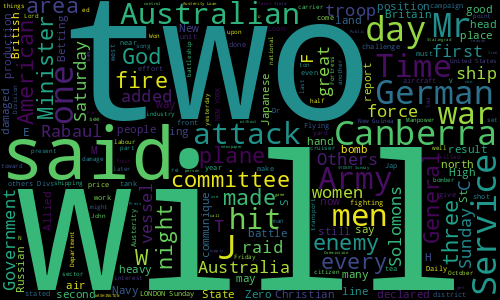

In [16]:
glue("page_text_wordcloud", wc, display=False)

```{glue:figure} page_text_wordcloud

Word cloud from the text content of the *Canberra Times*, 2 November 1942.
```

## PDFs of issues

(download-issue-as-pdf)=
### Download an issue as a PDF

````{margin}
```{seealso}
To download all the issues of a newspaper within a specified date range as PDFs see the GLAM Workbench notebook [Harvest the issues of a newspaper as PDFs](https://glam-workbench.net/trove-newspapers/#harvest-the-issues-of-a-newspaper-as-pdfs).
```
````

You can download PDFs of newspaper issues from the Trove web interface. However, automating this process is difficult. If you peek behind the web interface to see what happens when you click the download button, you'll see that it's a multi-step process. First the interface sends off a request to generate the issue PDF and gets back a token. It then uses that token to check with the Trove backend to see when the PDF generation is finished. When the backend signals the PDF is ready, the interface uses the token to download it. Complicated huh?

If you want to automate the download of article PDFs, you'll need to reproduce these steps. There's an example of how to do this with Python in [](/how-to/newspapers/get-newspaper-issue-article-pdfs).